In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from geopy.distance import geodesic
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, r2_score



print("Done!")

Done!


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

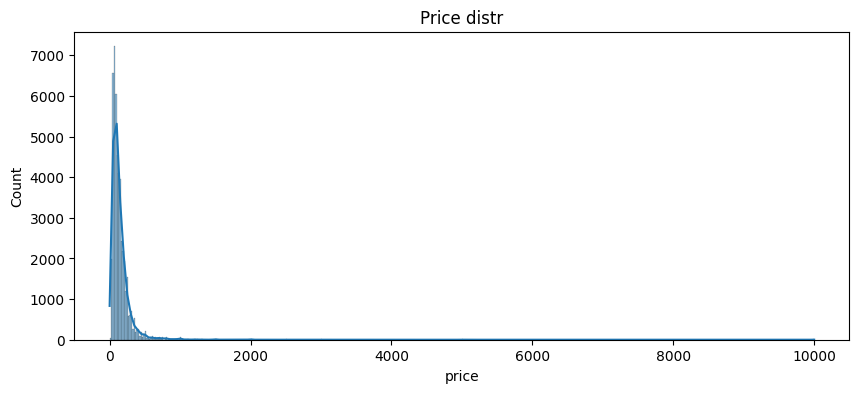

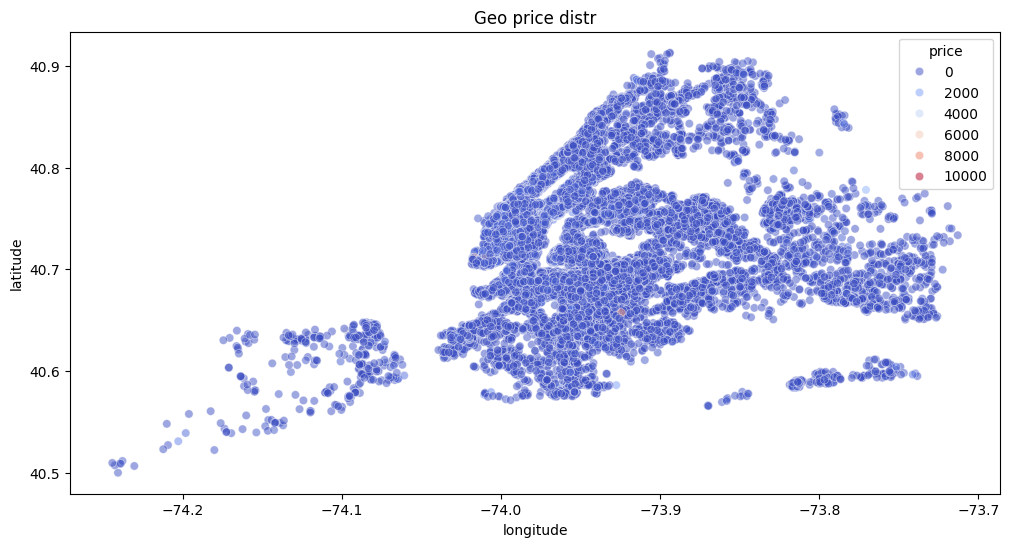

In [109]:
dataset = "D:/CDEK/AB_NYC_2019.csv"
data = pd.read_csv(dataset)
print(data.info())
print(data.describe())
print(data.isnull().sum())

plt.figure(figsize=(10, 4))
sns.histplot(data['price'], bins = 500, kde = True)
plt.title('Price distr')
plt.show

plt.figure(figsize=(12,6))
sns.scatterplot(x = 'longitude', y = 'latitude', hue = 'price', data=data, palette = 'coolwarm', alpha = 0.5)
plt.title("Geo price distr")
plt.show()

In [110]:
data['name'].fillna('Unknown', inplace = True)
data['host_name'].fillna('Unknown', inplace = True)
data['last_review'].fillna('2000-01-01', inplace=True) #for test preprocessing
data['reviews_per_month'].fillna(0, inplace=True)
data['last_review'] = pd.to_datetime(data['last_review'])
data['last_review_year'] = data['last_review'].dt.year
data['price_per_review'] = data['price'] / (data['number_of_reviews'] + 1)

TIMES_SQUARE = (40.7589, -73.9851)
data['distance_to_center'] = data.apply(lambda row: geodesic((row['latitude'], row['longitude']), TIMES_SQUARE).km, axis = 1)

label_encoder = LabelEncoder()
data['neighbourhood'] = label_encoder.fit_transform(data['neighbourhood'])
data['neighbourhood_group'] = label_encoder.fit_transform(data['neighbourhood_group'])
data['room_type'] = label_encoder.fit_transform(data['room_type'])

scaler = StandardScaler()
numeric_columns = ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

print(data.info())
print(data.head())

C:\Users\donat\AppData\Local\Temp\ipykernel_11180\1800126840.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['name'].fillna('Unknown', inplace = True)
C:\Users\donat\AppData\Local\Temp\ipykernel_11180\1800126840.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For examp

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              48895 non-null  int64         
 1   name                            48895 non-null  object        
 2   host_id                         48895 non-null  int64         
 3   host_name                       48895 non-null  object        
 4   neighbourhood_group             48895 non-null  int64         
 5   neighbourhood                   48895 non-null  int64         
 6   latitude                        48895 non-null  float64       
 7   longitude                       48895 non-null  float64       
 8   room_type                       48895 non-null  int64         
 9   price                           48895 non-null  int64         
 10  minimum_nights                  48895 non-null  float64       
 11  nu

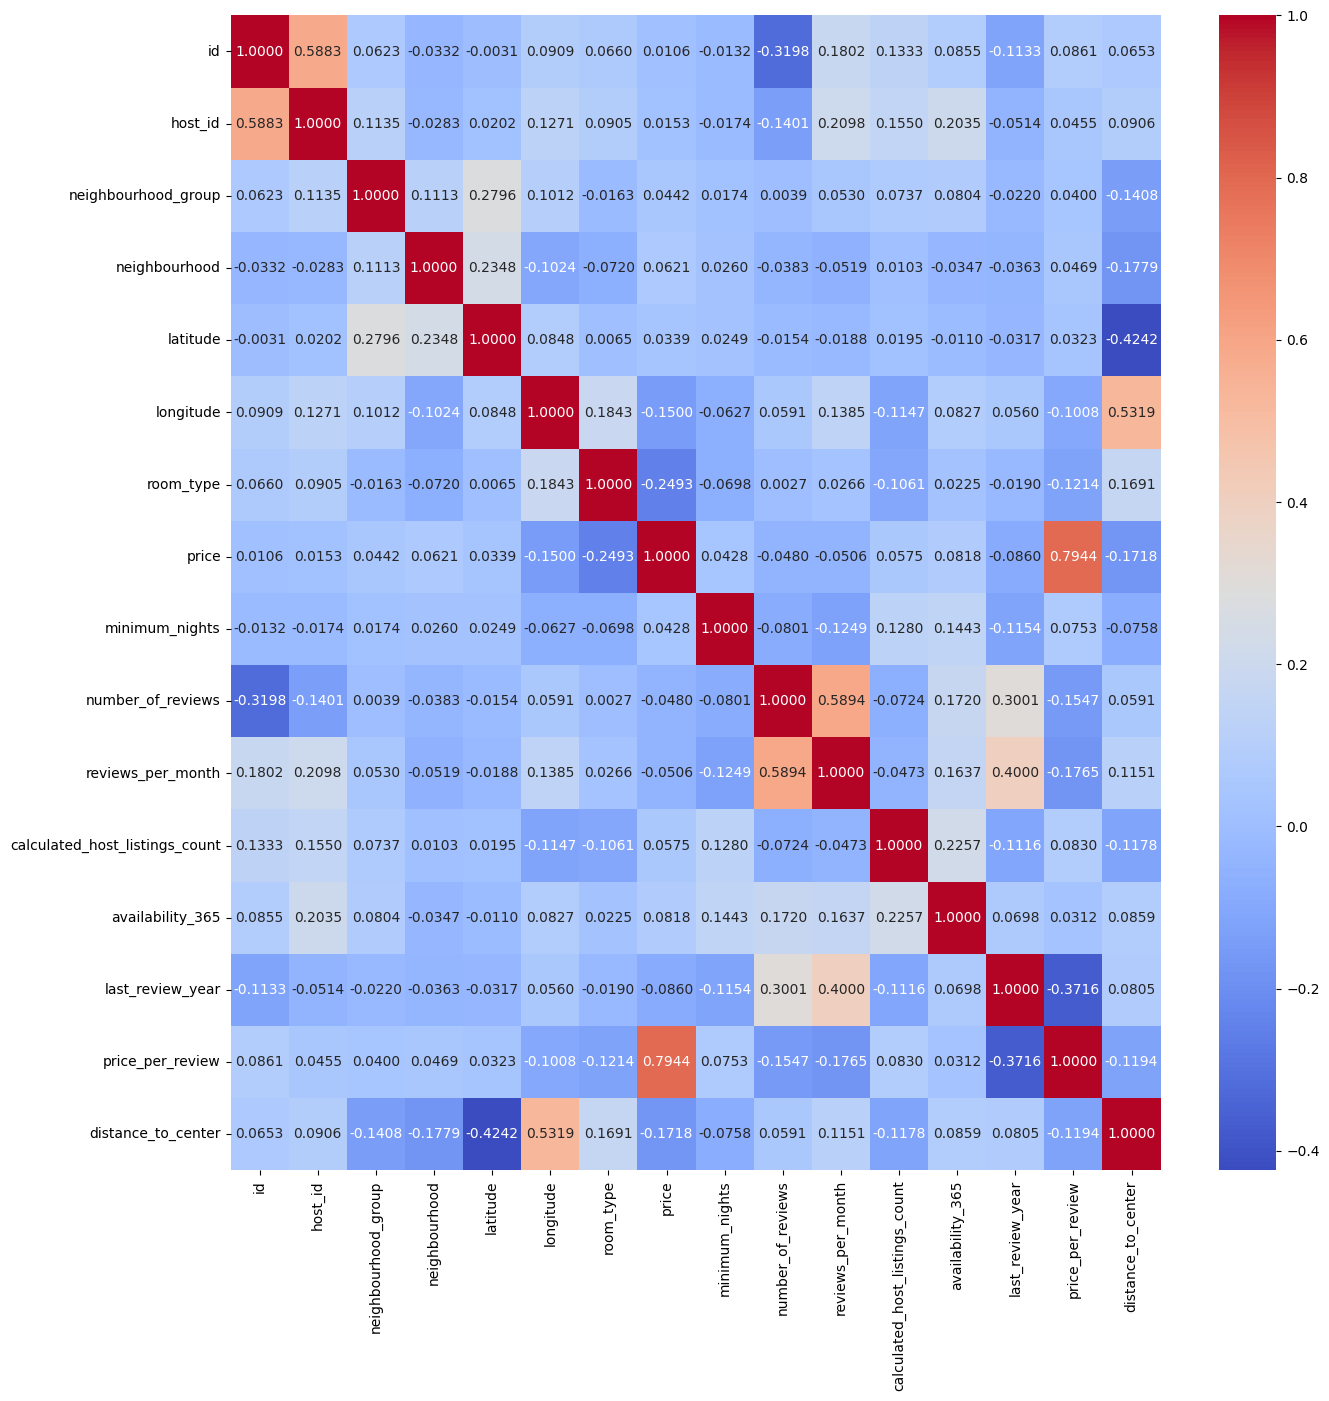

In [111]:
numeric_data = data.select_dtypes(include=[np.number])
correlation_matrix = numeric_data.corr()

plt.figure(figsize = (15, 15))
sns.heatmap(correlation_matrix, annot = True, fmt = ".4f", cmap = "coolwarm", cbar = True)
plt.show()


In [112]:
columns_to_drop = ['price_per_review', 'id', 'host_id', 'host_name']
data.drop(columns = columns_to_drop, inplace = True)

print(data.info())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   name                            48895 non-null  object        
 1   neighbourhood_group             48895 non-null  int64         
 2   neighbourhood                   48895 non-null  int64         
 3   latitude                        48895 non-null  float64       
 4   longitude                       48895 non-null  float64       
 5   room_type                       48895 non-null  int64         
 6   price                           48895 non-null  int64         
 7   minimum_nights                  48895 non-null  float64       
 8   number_of_reviews               48895 non-null  float64       
 9   last_review                     48895 non-null  datetime64[ns]
 10  reviews_per_month               48895 non-null  float64       
 11  ca

In [113]:
X = data.drop(columns = ['price'])
y = data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [ ]:
model_dt = DecisionTreeRegressor(max_depth = 2, random_state = 42)
model_dt.fit(X_train, y_train)

y_pred_dt = model_dt.predict(X_test)

mae_dt = mean_absolute_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)

print("DecisionTreeRegressor:")
print(f"MAE: {mae_dt:.4f}")
print(f"R²: {r2_dt:.4f}")

DecisionTreeRegressor:
MAE: 72.7485
R²: 0.0915


In [ ]:
model_rf = RandomForestRegressor(n_estimators = 1000, max_depth = 20, random_state = 42)
model_rf.fit(X_train, y_train)

y_pred_rf = model_rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("RandomForestRegressor:")
print(f"MAE: {mae_rf:.2f}")
print(f"R²: {r2_rf:.2f}")

RandomForestRegressor:
MAE: 64.38
R²: 0.14


In [ ]:
model_xgb = XGBRegressor(n_estimators = 5000, learning_rate = 0.001, max_depth = 10, random_state = 42)
model_xgb.fit(X_train, y_train)

y_pred_xgb = model_xgb.predict(X_test)

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("XGBRegressor:")
print(f"MAE: {mae_xgb:.2f}")
print(f"R²: {r2_xgb:.2f}")

XGBRegressor:
MAE: 63.36
R²: -0.02


In [76]:
model_lgbm = LGBMRegressor(n_estimators = 100, learning_rate = 0.1, max_depth = 2, random_state = 42)
model_lgbm.fit(X_train, y_train)

y_pred_lgbm = model_lgbm.predict(X_test)

mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm)
r2_lgbm = r2_score(y_test, y_pred_lgbm)

print("LGBMRegressor:")
print(f"MAE: {mae_lgbm:.2f}")
print(f"R²: {r2_lgbm:.2f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001180 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2101
[LightGBM] [Info] Number of data points in the train set: 34226, number of used features: 17
[LightGBM] [Info] Start training from score 154.122392
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

In [114]:
model_cb = CatBoostRegressor(iterations=1500, learning_rate=0.03, depth=5, random_state=42, verbose=100)
model_cb.fit(X_train, y_train)

y_pred_cb = model_cb.predict(X_test)

mae_cb = mean_absolute_error(y_test, y_pred_cb)
r2_cb = r2_score(y_test, y_pred_cb)

print("CatBoostRegressor:")
print(f"MAE: {mae_cb:.2f}")
print(f"R²: {r2_cb:.2f}")

CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=0]="Luxury Apt Close to JFK Airport": Cannot convert 'Luxury Apt Close to JFK Airport' to float